In [171]:
import os
import pandas as pd
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from datetime import datetime
from torch.utils.data import Dataset, DataLoader

sys.path.append(os.path.join(os.getcwd(), '../../common'))
from ppg_feature_processor import map_gender, map_age

In [172]:
# 获取当前日期
current_date = datetime.now().strftime("%Y-%m-%d")
# 构建导出的pth文件名以及ONNX文件名

outdir = 'outdir'
pth_file_path = os.path.join(outdir, f'ppg_sleep-best_model_{current_date}.pth')
onnx_file_path = os.path.join(outdir, f"ppg_sleep-best_model_{current_date}.onnx")

In [173]:
profile_columns = ['wave_quality', 'age', 'gender', 'label', 'id']

In [174]:
# # ---------------------------- 数据预处理 ----------------------------
def map_age(age):
    if age < 14:
        return [1, 0]
    elif age >= 14:
        return [0, 1]

# ---------------------------- 数据预处理 ----------------------------

def preprocess(df):
    df_new = df.copy()
    df_new[['age_0', 'age_1']] = df_new['age'].apply(map_age).apply(pd.Series)
    df_new[['gender_0', 'gender_1']] = df_new['gender'].apply(map_gender).apply(pd.Series)
    return df_new.drop(profile_columns, axis=1)

# 加载数据
train_pos_dataset = pd.read_pickle('./samples/train_pos_dataset.pkl')
train_neg_dataset = pd.read_pickle('./samples/train_neg_dataset.pkl')
val_pos_dataset = pd.read_pickle('./samples/val_pos_dataset.pkl')
val_neg_dataset = pd.read_pickle('./samples/val_neg_dataset.pkl')
test_pos_dataset = pd.read_pickle('./samples/test_pos_dataset.pkl')
test_neg_dataset = pd.read_pickle('./samples/test_neg_dataset.pkl')

# 应用预处理
train_pos_features = preprocess(train_pos_dataset)
train_neg_features = preprocess(train_neg_dataset)
val_pos_features = preprocess(val_pos_dataset)
val_neg_features = preprocess(val_neg_dataset)
test_pos_features = preprocess(test_pos_dataset)
test_neg_features = preprocess(test_neg_dataset)

In [175]:
print(train_pos_dataset.columns)

print(train_pos_features.columns)

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20',
       'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_HF', 'HRV_VHF',
       'HRV_TP', 'HRV_HFn', 'HRV_LnHF', 'wave_quality', 'label', 'id', 'age',
       'gender'],
      dtype='object')
Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20',
       'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_HF', 'HRV_VHF',
       'HRV_TP', 'HRV_HFn', 'HRV_LnHF', 'age_0', 'age_1', 'gender_0',
       'gender_1'],
      dtype='object')


Epoch [1/500], Loss: 0.6892, Avg Accuracy: 0.7333333333333333,  Positive Accuracy: 71.43%, Negative Accuracy: 75.00%
Best Accuracy Model: 0.7333333333333333
Epoch [2/500], Loss: 0.6880, Avg Accuracy: 0.7833333333333333,  Positive Accuracy: 71.43%, Negative Accuracy: 84.38%
Best Accuracy Model: 0.7833333333333333
Epoch [3/500], Loss: 0.6896, Avg Accuracy: 0.7833333333333333,  Positive Accuracy: 71.43%, Negative Accuracy: 84.38%
Epoch [4/500], Loss: 0.6896, Avg Accuracy: 0.7833333333333333,  Positive Accuracy: 71.43%, Negative Accuracy: 84.38%
Epoch [5/500], Loss: 0.6903, Avg Accuracy: 0.7833333333333333,  Positive Accuracy: 71.43%, Negative Accuracy: 84.38%
Epoch [6/500], Loss: 0.6869, Avg Accuracy: 0.7833333333333333,  Positive Accuracy: 71.43%, Negative Accuracy: 84.38%
Epoch [7/500], Loss: 0.6874, Avg Accuracy: 0.7833333333333333,  Positive Accuracy: 71.43%, Negative Accuracy: 84.38%
Epoch [8/500], Loss: 0.6854, Avg Accuracy: 0.7833333333333333,  Positive Accuracy: 71.43%, Negative A

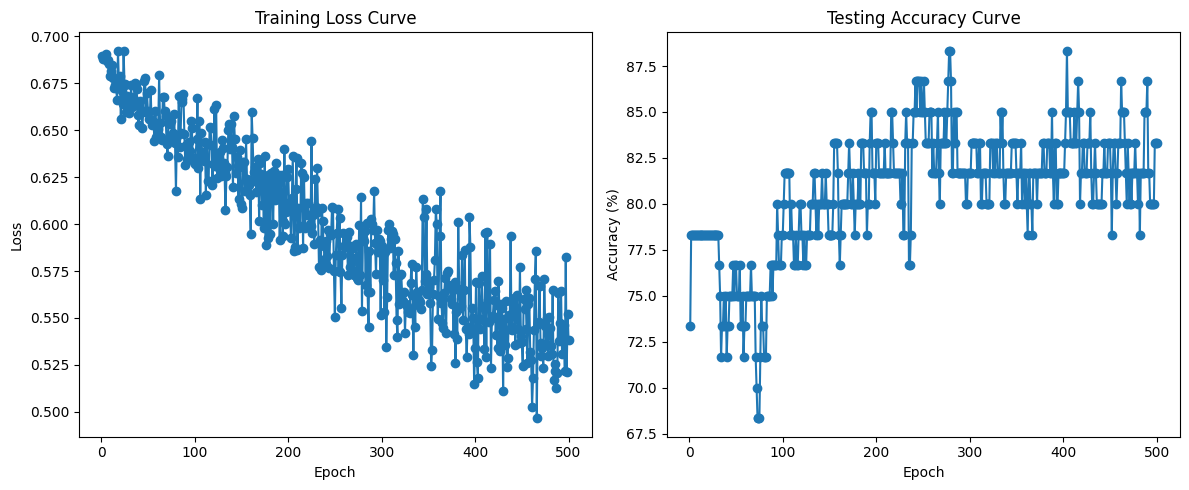

In [176]:
# ---------------------------- DNN 模型 ----------------------------

class DNNModel(nn.Module):
    def __init__(self, input_dim):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropOut = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropOut(x)
        x = self.relu(self.fc2(x))
        x = self.dropOut(x)
        x = self.sigmoid(self.fc3(x))
        return x

input_dim = train_pos_features.shape[1]
model = DNNModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# ---------------------------- 自定义数据加载器 ----------------------------

class BalancedDataset(Dataset):
    def __init__(self, pos_data, neg_data):
        self.pos_data = pos_data
        self.neg_data = neg_data
        self.pos_len = len(pos_data)
        self.neg_len = len(neg_data)

    def __len__(self):
        return min(self.pos_len, self.neg_len)

    def __getitem__(self, idx):
        pos_idx = np.random.randint(0, self.pos_len)
        neg_idx = np.random.randint(0, self.neg_len)
        
        pos_sample = self.pos_data.iloc[pos_idx].values.astype(np.float32)
        neg_sample = self.neg_data.iloc[neg_idx].values.astype(np.float32)

        X = np.vstack([pos_sample, neg_sample])
        y = np.array([1, 0], dtype=np.float32)

        return torch.tensor(X), torch.tensor(y)

class TestDataset(Dataset):
    def __init__(self, pos_data, neg_data):
        self.pos_data = pos_data
        self.neg_data = neg_data
        self.pos_len = len(pos_data)
        self.neg_len = len(neg_data)

    def __len__(self):
        return self.pos_len + self.neg_len

    def __getitem__(self, idx):
        if idx < self.pos_len:
            sample = self.pos_data.iloc[idx].values.astype(np.float32)
            label = 1
        else:
            idx -= self.pos_len
            sample = self.neg_data.iloc[idx].values.astype(np.float32)
            label = 0
        
        return torch.tensor(sample), torch.tensor(label, dtype=torch.float32)

# 初始化数据集和数据加载器
batch_size = 64
train_dataset = BalancedDataset(train_pos_features, train_neg_features)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


val_dataset = TestDataset(val_pos_features, val_neg_features)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


test_dataset = TestDataset(test_pos_features, test_neg_features)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------- 模型训练 ----------------------------

num_epochs = 500
train_losses = []
test_accuracies = []

def evaluate_model(model, data_loader):
    model.eval()  # 设置模型为评估模式
    pos_correct = 0
    neg_correct = 0
    pos_total = 0
    neg_total = 0

    with torch.no_grad():  # 关闭梯度计算
        for inputs, labels in data_loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() >= 0.5).float()

            # print(f"predicted: {predicted}")
            # Calculate accuracy for positive and negative samples
            pos_mask = (labels == 1).float()
            neg_mask = (labels == 0).float()
            pos_correct += ((predicted == labels) * pos_mask).sum().item()
            neg_correct += ((predicted == labels) * neg_mask).sum().item()
            pos_total += pos_mask.sum().item()
            neg_total += neg_mask.sum().item()
            

    pos_accuracy = pos_correct / pos_total if pos_total > 0 else 0
    neg_accuracy = neg_correct / neg_total if neg_total > 0 else 0
    return pos_accuracy, neg_accuracy, (pos_correct+neg_correct) / (pos_total + neg_total)


best_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy calculation
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    avg_accuracy = correct / total
    train_losses.append(avg_loss)
    
    # Evaluate on test set
    pos_accuracy, neg_accuracy, accuracy = evaluate_model(model, val_loader)
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Avg Accuracy: {accuracy},  Positive Accuracy: {pos_accuracy * 100:.2f}%, Negative Accuracy: {neg_accuracy * 100:.2f}%')

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), pth_file_path)
        print("Best Accuracy Model: {}".format(best_accuracy))

        # Export the best model to ONNX
        dummy_input = torch.randn(1, input_dim)
        torch.onnx.export(model, dummy_input, onnx_file_path, input_names=['input'], output_names=['output'])
    

# ---------------------------- 绘制训练曲线 ----------------------------

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), [acc * 100 for acc in test_accuracies], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy Curve')

plt.tight_layout()
plt.show()

In [177]:
import glob
import glob
import numpy as np
import onnxruntime as ort

from collections import defaultdict

In [178]:
print(test_pos_dataset.columns)

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20',
       'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_HF', 'HRV_VHF',
       'HRV_TP', 'HRV_HFn', 'HRV_LnHF', 'wave_quality', 'label', 'id', 'age',
       'gender'],
      dtype='object')


In [179]:
import enum


def get_onnxfile():
    outdir = './outdir'
    onnx_files = glob.glob(os.path.join(outdir, '*.onnx'))
    # 如果找到的文件不为空
    if onnx_files:
        # 按文件名排序
        onnx_files.sort()

        # 选择最后一个文件
        last_onnx_file = onnx_files[-1]
        return last_onnx_file

onnx_model_path = get_onnxfile()
def get_onnxfile():
    outdir = './outdir'
    onnx_files = glob.glob(os.path.join(outdir, '*.onnx'))
    if onnx_files:
        onnx_files.sort()
        last_onnx_file = onnx_files[-1]
        return last_onnx_file

onnx_model_path = get_onnxfile()
ort_session = ort.InferenceSession(onnx_model_path)

# 预测函数
def predict(features):
    inputs = {ort_session.get_inputs()[0].name: features}
    outputs = ort_session.run(None, inputs)
    return outputs[0]

for idx, pair_data in enumerate([[test_neg_dataset, test_neg_features], [test_pos_dataset, test_pos_features]]):
    if idx == 0:
        print("\nTest for Negative subjects:")
    else:
        print("\nTest for Positive subjects:")

    # 加载测试数据集
    # 计算每个 subject 的准确率
    subject_results = defaultdict(list)

    for (_, row_dataset), (_, features), in zip(pair_data[0].iterrows(), pair_data[1].iterrows()):
        subject = row_dataset['id']
        label = row_dataset['label']

        features = np.array(features, dtype=np.float32)  # 确保 features 的数据类型与模型输入匹配
        features = features.reshape(1, -1)  # 调整形状以匹配模型输入
        prediction = predict(features)
        predicted_label = (prediction >= 0.5).astype(int)  # 使用阈值 0.5 将预测概率转换为类标签
        subject_results[subject].append((predicted_label, label))

    subject_accuracies = {}
    for subject, results in subject_results.items():
        correct = sum(1 for pred, label in results if pred == label)
        accuracy = correct / len(results)
        subject_accuracies[subject] = accuracy

    # 输出每个 subject 的准确度
    correct_count = 0
    for subject, accuracy in subject_accuracies.items():
        print(f'Subject: {subject}, Accuracy: {accuracy:.2f}')
        if accuracy > 0.5:
            correct_count += 1
        elif accuracy == 0.5:
            correct_count += 0.5
    print(f"subject accuracy: {(correct_count / len(subject_accuracies)):.2f}")


Test for Negative subjects:
Subject: 66883352438405515203389903841888282980, Accuracy: 0.00
Subject: 248745867043481860061400522592757429141, Accuracy: 1.00
Subject: 95162145089410043130590439710288862875, Accuracy: 1.00
Subject: 129248284799429495306837089790351674777, Accuracy: 1.00
Subject: 53432263590786069539548595940834778143, Accuracy: 0.50
Subject: 147359196293566602169362260165807304353, Accuracy: 0.80
Subject: 116653212415901981538518364005483413701, Accuracy: 1.00
Subject: 74777090103596991100156529879998594598, Accuracy: 1.00
Subject: 291726336157896493559959962336883513986, Accuracy: 0.20
Subject: 86735914967402468079245225254462550932, Accuracy: 1.00
Subject: 279596114491335403076296161548798302049, Accuracy: 0.00
Subject: 303451417278675614732880171299900074054, Accuracy: 0.67
Subject: 217401908842290417389877459413956699848, Accuracy: 1.00
subject accuracy: 0.73

Test for Positive subjects:
Subject: 50112629529999942369474763918237775694, Accuracy: 0.00
Subject: 292243